In [1]:
import coincident
import geopandas as gpd
%load_ext autoreload
%autoreload 2

/home/jehayes/coincident/src/coincident/search/main.py:14: UserWarning: Unable to authenticate with Maxar API. Please set MAXAR_API_KEY environment variable.
  from coincident.search import neon_api, opentopo_api, stac, wesm


NEON
---

In [2]:
gf_neon_usgs = gpd.read_file("/mnt/c/Users/JackE/uw/STV/data/PCD_neon_3dep_feb25.geojson")
aoi = gf_neon_usgs.iloc[[1]]
aoi
# site_id is the NEON site id of interest and collect_start is our datetime of interest

,collect_start,collect_end,site_id,provisional,start_datetime,end_datetime,overlap_area_km2,min_date_diff,workunit,start_3dep,end_3dep,geometry
1,2022-06-01,2022-06-30,LIRO,0.0,2022-06-01,2022-06-30,14.757825,17,WI_12County_1_B22,2022-05-04,2022-05-15,"POLYGON ((-89.72301 45.98401, -89.68145 45.984..."


In [3]:
coincident.io.xarray.load_neon_dem?

Signature:
coincident.io.xarray.load_neon_dem(
    aoi: 'gpd.GeoDataFrame',
    datetime_str: 'str',
    site_id: 'str',
    product: 'str',
    res: 'int' = 1,
    clip: 'bool' = True,
) -> 'xr.DataArray'
Docstring:
Load and merge NEON LiDAR tiles (DSM, DTM, or CHM) based on an AOI by querying the NEON API.

Steps:
  1. Convert the datetime string to a month string in the format YYYY-MM.
  2. Determine appropriate UTM CRS for the AOI.
  3. Query the NEON API using a preset product code.
  4. Filter the returned files based on product type and spatial intersection.
  5. Load and optionally coarsen each GeoTIFF tile.
  6. Merge the tiles and optionally clip the mosaic to the AOI.

Returns:
  xr.DataArray: The merged (and optionally clipped) LiDAR mosaic.
File:      ~/coincident/src/coincident/io/xarray.py
Type:      function

In [4]:
datetime_str = aoi.collect_start.item().strftime('%Y-%m-%d')
site_id = aoi.site_id.item()
datetime_str, site_id

('2022-06-01', 'LIRO')

In [ ]:
# same use case took less than 6 seconds in a different notebook...
# takes 27 here, I can't use the %%time command because of the weird error described below
test = coincident.io.xarray.load_neon_dem(aoi,
                                          datetime_str=datetime_str,
                                          site_id=site_id,
                                          product="dsm")

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1139: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1139: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1139: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1139: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1139: RuntimeWarning: 

%%time magic function call for the above cell always results in:

ConnectionError: HTTPConnectionPool(host='data.neonscience.org', port=80): Max retries exceeded with url: /api/v0/data/DP3.30024.001/LIRO/2022-06 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7fdd42e68620>: Failed to resolve 'data.neonscience.org' ([Errno -3] Temporary failure in name resolution)"))

In [7]:
test

<xarray.DataArray 'elevation' (y: 4692, x: 3373)> Size: 63MB
dask.array<getitem, shape=(4692, 3373), dtype=float32, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 27kB 2.891e+05 2.891e+05 ... 2.925e+05 2.925e+05
  * y            (y) float64 38kB 5.096e+06 5.096e+06 ... 5.1e+06 5.1e+06
    spatial_ref  int64 8B 0

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


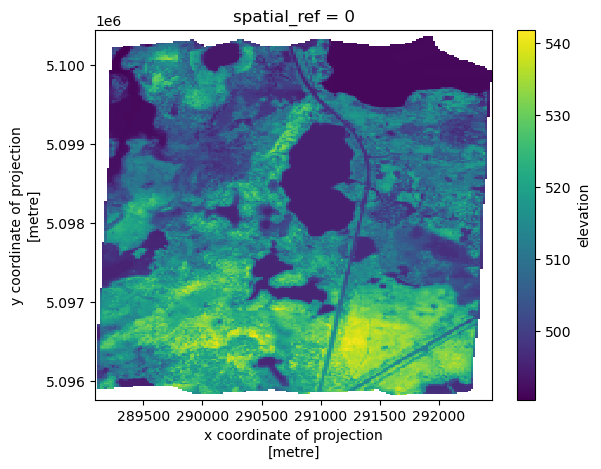

In [8]:
test.coarsen(x=20,y=20, boundary='trim').mean().plot.imshow();

USGS 3DEP
---

In [2]:
gf_neon_usgs = gpd.read_file("/mnt/c/Users/JackE/uw/STV/data/PCD_neon_3dep_feb25.geojson")
aoi = gf_neon_usgs.iloc[[1]]

In [3]:
aoi

,collect_start,collect_end,site_id,provisional,start_datetime,end_datetime,overlap_area_km2,min_date_diff,workunit,start_3dep,end_3dep,geometry
1,2022-06-01,2022-06-30,LIRO,0.0,2022-06-01,2022-06-30,14.757825,17,WI_12County_1_B22,2022-05-04,2022-05-15,"POLYGON ((-89.72301 45.98401, -89.68145 45.984..."


In [4]:
aoi.total_bounds

array([-89.72300752,  45.9840129 , -89.68144678,  46.02525724])

In [5]:
gf = coincident.search.search(
    dataset="3dep",
    intersects=aoi,
    datetime=["2019", "2024"],
)

In [6]:
gf.columns

Index(['minx', 'maxx', 'miny', 'maxy', 'geometry', 'workunit', 'workunit_id',
       'project', 'project_id', 'start_datetime', 'end_datetime', 'ql', 'spec',
       'p_method', 'dem_gsd_meters', 'horiz_crs', 'vert_crs', 'geoid',
       'lpc_pub_date', 'lpc_update', 'lpc_category', 'lpc_reason',
       'sourcedem_pub_date', 'sourcedem_update', 'sourcedem_category',
       'sourcedem_reason', 'onemeter_category', 'onemeter_reason',
       'seamless_category', 'seamless_reason', 'lpc_link', 'sourcedem_link',
       'metadata_link', 'collection', 'datetime', 'dayofyear', 'duration'],
      dtype='object')

In [7]:
gf

,minx,maxx,miny,maxy,geometry,workunit,workunit_id,project,project_id,start_datetime,...,onemeter_reason,seamless_category,seamless_reason,lpc_link,sourcedem_link,metadata_link,collection,datetime,dayofyear,duration
fid,,,,,,,,,,,,,,,,,,,,,
2885,-90.046097,-88.931244,45.855568,46.300938,"POLYGON ((-88.93124 45.85557, -88.93124 46.300...",WI_12County_1_B22,230107,WI_12County_B22,230110,2022-05-04,...,Meets 3DEP 1-m DEM requirements,Meets,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,3DEP,2022-05-09 12:00:00,129,11
2341,-93.156670,-87.689812,43.532413,46.429382,"POLYGON ((-87.68981 43.53241, -87.68981 46.429...",WI_Oshkosh_3Rivers_B2_2018,172951,WI_Oshkosh_3Rivers_2018_D19,172420,2019-04-20,...,Meets 3DEP 1-m DEM requirements,Meets,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,3DEP,2019-05-05 12:00:00,125,31


In [8]:
coincident.search.wesm.query_tnm_api?

Signature:
coincident.search.wesm.query_tnm_api(
    polygon_str: 'str',
    tnmdataset: 'str' = 'Digital Elevation Model (DEM) 1 meter',
) -> 'list[dict[str, Any]]'
Docstring:
Query the TNM API for USGS DEM products that intersect the given polygon.

Parameters:
  polygon_str (str): Polygon coordinates string in the required API format.
  tnmdataset (str): The dataset name for the TNM API (default is "Digital Elevation Model (DEM) 1 meter").

Returns:
  list: A list of JSON items returned from the TNM API.
File:      ~/coincident/src/coincident/search/wesm.py
Type:      function

In [9]:
coincident.io.xarray.load_usgs_dem?

Signature:
coincident.io.xarray.load_usgs_dem(
    aoi: 'gpd.GeoDataFrame',
    project: 'str',
    tnmdataset: 'str' = 'Digital Elevation Model (DEM) 1 meter',
    res: 'int' = 1,
    clip: 'bool' = True,
) -> 'xr.DataArray'
Docstring:
Load and merge USGS 1-meter DEM tiles based on an AOI by querying the TNM API.

Steps:
  1. Reproject the AOI to EPSG:4326.
  2. Extract the first geometry from the exploded AOI (to match the geometry type used in search.search).
  3. Convert the geometry to a polygon string using a private helper.
  4. Query the TNM API via the moved function in coincident.search.wesm.
  5. Filter the API items using a private helper.
  6. Load and optionally coarsen each GeoTIFF tile.
  7. Merge the DEM tiles and optionally clip the mosaic to the AOI.

Returns:
  xr.DataArray: The merged (and optionally clipped) DEM mosaic.
File:      ~/coincident/src/coincident/io/xarray.py
Type:      function

In [10]:
%%time
test = coincident.io.xarray.load_usgs_dem(aoi, 'WI_12County_B22')

CPU times: user 2.94 s, sys: 1.89 s, total: 4.83 s
Wall time: 9.94 s


In [11]:
test

<xarray.DataArray 'elevation' (y: 4669, x: 4945)> Size: 92MB
dask.array<getitem, shape=(4669, 4945), dtype=float32, chunksize=(4235, 4945), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 40kB 2.9e+05 2.9e+05 ... 2.925e+05 2.925e+05
  * y            (y) float64 37kB 5.096e+06 5.096e+06 ... 5.1e+06 5.1e+06
    spatial_ref  int64 8B 0

In [14]:
%%time
test = coincident.io.xarray.load_usgs_dem(aoi, 'WI_12County_B22', clip=False)

CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 4.14 s


In [15]:
test

<xarray.DataArray 'elevation' (y: 20024, x: 20024)> Size: 2GB
dask.array<_nanmax_skip-aggregate, shape=(20024, 20024), dtype=float32, chunksize=(5006, 5006), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 160kB 2.9e+05 2.9e+05 2.9e+05 ... 3e+05 3e+05 3e+05
  * y            (y) float64 160kB 5.09e+06 5.09e+06 ... 5.11e+06 5.11e+06
    spatial_ref  int64 8B 0

In [16]:
%%time
test = coincident.io.xarray.load_usgs_dem(aoi, 'WI_12County_B22', 
                                            clip=False,res=10)

CPU times: user 111 ms, sys: 1.89 ms, total: 113 ms
Wall time: 4.16 s


In [17]:
test

<xarray.DataArray 'elevation' (y: 2002, x: 2002)> Size: 16MB
dask.array<_nanmax_skip-aggregate, shape=(2002, 2002), dtype=float32, chunksize=(502, 502), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 16kB 2.9e+05 2.9e+05 2.9e+05 ... 3e+05 3e+05 3e+05
  * y            (y) float64 16kB 5.09e+06 5.09e+06 ... 5.11e+06 5.11e+06
    spatial_ref  int64 8B 0